<a href="https://colab.research.google.com/github/machadoprx/CoolConvNN/blob/master/multi_modal_ep_autoencoder_plus_edgeprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dataset

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Add, Dropout, concatenate, Activation, BatchNormalization, Average, LayerNormalization, Multiply
from keras.regularizers import l2
from keras import regularizers
import gc

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/karansikka1/documentIntent_emnlp19/

Cloning into 'documentIntent_emnlp19'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 40 (delta 24), reused 34 (delta 20), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
!tar -xvf documentIntent_emnlp19/resnet18_feat.tar

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
resnet18_feat/._37031415_213105772724396_5071062925699973120_n.npy
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
resnet18_feat/37031415_213105772724396_5071062925699973120_n.npy
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
resnet18_feat/._36881666_2052453971671646_1508872000209158144_n.npy
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
resnet18_feat/36881666_2052453971

In [ ]:
import pandas as pd
split = 1#@param
 
df_data_train = pd.read_json(f'documentIntent_emnlp19/splits/train_split_{split}.json')
df_data_train

,id,semiotic,intent,caption,contextual,tags,orig_caption,url,likes
0,36703597_2067741713544288_5623514759279149056_n,parallel,advocate,agreed hatefulcriticizing comments incoming ar...,minimal,"[motivation, alm, liberal, trump, USA, liberta...",Agreed. Hateful/criticizing comments incoming....,https://scontent-lga3-1.cdninstagram.com/vp/86...,896
1,36781218_510074496092222_5122086389852143616_n,additive,inform,michael jordan takes off from the free throw l...,transcendent,[],Michael Jordan takes off from the free throw l...,https://scontent-lga3-1.cdninstagram.com/vp/eb...,79703
2,36846826_1487306511373814_8684508792605376512_n,divergent,entertain,a here i ambegging for treatsand had my pictur...,minimal,"[feedme, cute, dauchshund, cutedogs, dogsofins...",A #latergram .\n.\nHere I am...begging for tre...,https://scontent-lga3-1.cdninstagram.com/vp/29...,1
3,36971595_1827021124043766_3117028212484341760_n,parallel,expose,pairs roasted tomatoes with creamy burrata for...,close,"[deliciousness, foodie, foodporn, food, cookin...",pairs roasted tomatoes with creamy burrata for...,https://scontent-lga3-1.cdninstagram.com/vp/9a...,11
4,36897752_548626945552220_1059183761767268352_n,additive,provoke,the only reason so many fools hate trump is be...,transcendent,"[firstamendment, trump, senate, house, america...",The only reason so many fools hate trump is be...,https://scontent-lga3-1.cdninstagram.com/vp/2a...,17
...,...,...,...,...,...,...,...,...,...
1034,37520493_621812881526699_332629879746985984_n,parallel,provoke,never too late or just perez doing the least m...,transcendent,"[trump, bacon, democrats, perez, thedonald, po...",Never too late? Or just Perez doing the least ...,https://scontent-lga3-1.cdninstagram.com/vp/bc...,26
1035,36564929_246144526114944_2253630028099092480_n,additive,entertain,we hope youre enjoying the summer sun this wee...,close,[:],#TateWeather: We hope you're enjoying the summ...,https://scontent-lga3-1.cdninstagram.com/vp/0e...,6581
1036,36985441_259404757979032_3985049834674454528_n,parallel,entertain,own the day own the week lets do it,close,[gym115randwickgym115randwick],"Own the day own the week, lets do it!!! #gym11...",https://scontent-lga3-1.cdninstagram.com/vp/c5...,23
1037,36980872_233524380608917_932879747233349632_n,divergent,provoke,in a recent meeting centrist democrats met to ...,close,"[eattherich, killyourmasters, staywoke, fascis...",In a recent meeting Centrist Democrats met to ...,https://scontent-lga3-1.cdninstagram.com/vp/58...,3


In [ ]:
df_data_test = pd.read_json(f'documentIntent_emnlp19/splits/val_split_{split}.json')
df_data_test

,id,semiotic,intent,caption,contextual,tags,orig_caption,url,likes
0,36594545_229498391208268_7258782755041837056_n,parallel,entertain,the gorgeous rooftops of safed zefat,close,"[eilat, ilovetelaviv, israel, ashkelon, shalom...",The gorgeous rooftops of Safed / Zefat ✡️#isra...,https://scontent-lga3-1.cdninstagram.com/vp/a4...,306
1,36912676_409818882838480_8318691412799389696_n,divergent,expose,growing the wheels day by day,minimal,[],Growing the wheels day by day 😏😈,https://scontent-lga3-1.cdninstagram.com/vp/a5...,52
2,37244530_635180723525255_67967032825479168_n,parallel,expose,a better view soft boiled egg black oil tonkat...,close,"[foodblogger, foodie, foodig, foodigram, japan...",a better view + soft boiled egg ‼️\n.\n>> blac...,https://scontent-lga3-1.cdninstagram.com/vp/22...,3
3,37238155_1848493018545163_6287451192104583168_n,parallel,promote,peel off gel tint is changing the brow game th...,close,"[Tattoobrow, mnybrows]",#Tattoobrow peel-off gel tint is changing the ...,https://scontent-ort2-1.cdninstagram.com/vp/8d...,27430
4,37215235_642181076140653_8547847146609573888_n,additive,expose,me randowski plumtreeboss randowski plum tree ...,close,"[TWITTER, YOUTUBE, FACEBOOK, WATSAPP, REVERBNA...",👊👑💯NEW ME. 💪😘👊😍✌😇🙋🙌💜💛💚💗 😍😍😍😍😍😘😘😘👑👑👑👑👑💯💯💯💞💞💞💞💞💞...,https://scontent-lga3-1.cdninstagram.com/vp/a1...,1
...,...,...,...,...,...,...,...,...,...
255,37055561_809795579409555_389722046789058560_n,parallel,inform,castle stalker has a long and turbulent histor...,close,"[travelinggram, goexplore, master_shots, gameo...",Castle Stalker has a long and turbulent histor...,https://scontent-lga3-1.cdninstagram.com/vp/25...,3828
256,36809483_271747156931329_785897986314993664_n,parallel,expose,shalom via goldi,minimal,"[standwithisrael, iloveisrael, tlvcity, ashkel...",Shalom ✡️. Via 2goldi ⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️.\n#is...,https://scontent-lga3-1.cdninstagram.com/vp/c8...,880
257,36136851_1722459914512476_8305588197723734016_n,parallel,provoke,wall,minimal,"[alexandriaocasiocortez, trump, ny14, immigran...",😂😂😂 WALL #bernieorbust #progressive #bernie #b...,https://scontent-lga3-1.cdninstagram.com/vp/f8...,411
258,36832483_2012928692370805_5293934147398533120_n,parallel,promote,join the brotherhood swedish coastal rangers r...,close,"[pewpewlife, soldat, militär, navy, firearm, t...","#swedisharmedforces 🇸🇪\nJoin the brotherhood, ...",https://scontent-lga3-1.cdninstagram.com/vp/50...,500


# Extracting features from images (ResNet18)

In [ ]:
!pip install scikit-learn==0.23.2
import numpy as np
from sklearn import preprocessing
L_img_features = []
for index,row in df_data_train.iterrows():
  features = np.load('resnet18_feat/'+row['id']+'.npy')
  L_img_features.append(features)

L_img_features = preprocessing.scale(np.array(L_img_features))

df_data_train['img_features'] = list(L_img_features)
df_data_train

     |████████████████████████████████| 6.8MB 5.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


,id,semiotic,intent,caption,contextual,tags,orig_caption,url,likes,img_features
0,36703597_2067741713544288_5623514759279149056_n,parallel,advocate,agreed hatefulcriticizing comments incoming ar...,minimal,"[motivation, alm, liberal, trump, USA, liberta...",Agreed. Hateful/criticizing comments incoming....,https://scontent-lga3-1.cdninstagram.com/vp/86...,896,"[-1.0632712, 0.11813723, -0.9001717, -0.811203..."
1,36781218_510074496092222_5122086389852143616_n,additive,inform,michael jordan takes off from the free throw l...,transcendent,[],Michael Jordan takes off from the free throw l...,https://scontent-lga3-1.cdninstagram.com/vp/eb...,79703,"[1.2796748, 0.86217415, 0.9418957, -0.1870805,..."
2,36846826_1487306511373814_8684508792605376512_n,divergent,entertain,a here i ambegging for treatsand had my pictur...,minimal,"[feedme, cute, dauchshund, cutedogs, dogsofins...",A #latergram .\n.\nHere I am...begging for tre...,https://scontent-lga3-1.cdninstagram.com/vp/29...,1,"[-0.42342958, 0.5732302, -1.2471988, -0.386482..."
3,36971595_1827021124043766_3117028212484341760_n,parallel,expose,pairs roasted tomatoes with creamy burrata for...,close,"[deliciousness, foodie, foodporn, food, cookin...",pairs roasted tomatoes with creamy burrata for...,https://scontent-lga3-1.cdninstagram.com/vp/9a...,11,"[0.16592762, -0.8411925, 0.42989692, -0.501414..."
4,36897752_548626945552220_1059183761767268352_n,additive,provoke,the only reason so many fools hate trump is be...,transcendent,"[firstamendment, trump, senate, house, america...",The only reason so many fools hate trump is be...,https://scontent-lga3-1.cdninstagram.com/vp/2a...,17,"[0.79511756, 1.4041145, 0.9643416, 1.4123882, ..."
...,...,...,...,...,...,...,...,...,...,...
1034,37520493_621812881526699_332629879746985984_n,parallel,provoke,never too late or just perez doing the least m...,transcendent,"[trump, bacon, democrats, perez, thedonald, po...",Never too late? Or just Perez doing the least ...,https://scontent-lga3-1.cdninstagram.com/vp/bc...,26,"[-0.94843274, 0.8495149, -1.2378095, -1.219444..."
1035,36564929_246144526114944_2253630028099092480_n,additive,entertain,we hope youre enjoying the summer sun this wee...,close,[:],#TateWeather: We hope you're enjoying the summ...,https://scontent-lga3-1.cdninstagram.com/vp/0e...,6581,"[-0.260906, -1.0822254, -0.69868124, -1.216641..."
1036,36985441_259404757979032_3985049834674454528_n,parallel,entertain,own the day own the week lets do it,close,[gym115randwickgym115randwick],"Own the day own the week, lets do it!!! #gym11...",https://scontent-lga3-1.cdninstagram.com/vp/c5...,23,"[-1.1088728, -0.47571078, -0.7590779, -0.58235..."
1037,36980872_233524380608917_932879747233349632_n,divergent,provoke,in a recent meeting centrist democrats met to ...,close,"[eattherich, killyourmasters, staywoke, fascis...",In a recent meeting Centrist Democrats met to ...,https://scontent-lga3-1.cdninstagram.com/vp/58...,3,"[-0.95611113, 1.725372, 0.045712072, 0.4466805..."


In [ ]:
len(list(df_data_train.iloc[0]['img_features']))

512

In [ ]:
import numpy as np

L_img_features = []
for index,row in df_data_test.iterrows():
  features = np.load('resnet18_feat/'+row['id']+'.npy')
  L_img_features.append(features)

L_img_features = preprocessing.scale(np.array(L_img_features))

df_data_test['img_features'] = list(L_img_features)
df_data_test

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


,id,semiotic,intent,caption,contextual,tags,orig_caption,url,likes,img_features
0,36594545_229498391208268_7258782755041837056_n,parallel,entertain,the gorgeous rooftops of safed zefat,close,"[eilat, ilovetelaviv, israel, ashkelon, shalom...",The gorgeous rooftops of Safed / Zefat ✡️#isra...,https://scontent-lga3-1.cdninstagram.com/vp/a4...,306,"[-0.6344061, -0.7883239, 0.2946396, -1.2905669..."
1,36912676_409818882838480_8318691412799389696_n,divergent,expose,growing the wheels day by day,minimal,[],Growing the wheels day by day 😏😈,https://scontent-lga3-1.cdninstagram.com/vp/a5...,52,"[-0.32770687, 0.8952486, -0.17297025, 1.079068..."
2,37244530_635180723525255_67967032825479168_n,parallel,expose,a better view soft boiled egg black oil tonkat...,close,"[foodblogger, foodie, foodig, foodigram, japan...",a better view + soft boiled egg ‼️\n.\n>> blac...,https://scontent-lga3-1.cdninstagram.com/vp/22...,3,"[0.7553731, -0.40527716, 0.050985236, -0.17676..."
3,37238155_1848493018545163_6287451192104583168_n,parallel,promote,peel off gel tint is changing the brow game th...,close,"[Tattoobrow, mnybrows]",#Tattoobrow peel-off gel tint is changing the ...,https://scontent-ort2-1.cdninstagram.com/vp/8d...,27430,"[2.0726666, -0.81973165, -0.31382656, 0.498072..."
4,37215235_642181076140653_8547847146609573888_n,additive,expose,me randowski plumtreeboss randowski plum tree ...,close,"[TWITTER, YOUTUBE, FACEBOOK, WATSAPP, REVERBNA...",👊👑💯NEW ME. 💪😘👊😍✌😇🙋🙌💜💛💚💗 😍😍😍😍😍😘😘😘👑👑👑👑👑💯💯💯💞💞💞💞💞💞...,https://scontent-lga3-1.cdninstagram.com/vp/a1...,1,"[-0.4450921, -0.83025223, -0.8491806, 2.566396..."
...,...,...,...,...,...,...,...,...,...,...
255,37055561_809795579409555_389722046789058560_n,parallel,inform,castle stalker has a long and turbulent histor...,close,"[travelinggram, goexplore, master_shots, gameo...",Castle Stalker has a long and turbulent histor...,https://scontent-lga3-1.cdninstagram.com/vp/25...,3828,"[-0.75008714, -0.713795, -0.63033634, -0.88595..."
256,36809483_271747156931329_785897986314993664_n,parallel,expose,shalom via goldi,minimal,"[standwithisrael, iloveisrael, tlvcity, ashkel...",Shalom ✡️. Via 2goldi ⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️.\n#is...,https://scontent-lga3-1.cdninstagram.com/vp/c8...,880,"[1.3225888, -0.7532054, 3.2370965, 0.7971138, ..."
257,36136851_1722459914512476_8305588197723734016_n,parallel,provoke,wall,minimal,"[alexandriaocasiocortez, trump, ny14, immigran...",😂😂😂 WALL #bernieorbust #progressive #bernie #b...,https://scontent-lga3-1.cdninstagram.com/vp/f8...,411,"[-0.30624598, 0.426397, 0.41993323, 1.305059, ..."
258,36832483_2012928692370805_5293934147398533120_n,parallel,promote,join the brotherhood swedish coastal rangers r...,close,"[pewpewlife, soldat, militär, navy, firearm, t...","#swedisharmedforces 🇸🇪\nJoin the brotherhood, ...",https://scontent-lga3-1.cdninstagram.com/vp/50...,500,"[-1.0457369, -0.069384895, 0.79452944, -0.9109..."


# Training a BERT classifier (initial model)

In [ ]:
!pip install ktrain
import keras
import ktrain
from ktrain import text
import os
 
#os.environ["CUDA_VISIBLE_DEVICES"]="2";

     |████████████████████████████████| 25.3MB 53.3MB/s 
     |████████████████████████████████| 983kB 38.5MB/s 
     |████████████████████████████████| 266kB 48.1MB/s 
     |████████████████████████████████| 1.3MB 38.9MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
     |████████████████████████████████| 471kB 37.6MB/s 
     |████████████████████████████████| 890kB 40.7MB/s 
     |████████████████████████████████| 2.9MB 49.0MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.4-cp37-none-any.whl size=25276443 sha256=3a484bf4162dfc174b4869dfaa469617c17351574b8a0ea948d2ba8729b1cb7a
  Stored in directory: /root/.cache/pip/wheels/1b/77/8a/bdceaabc308e7178d575278bf6143b7d1a9b939a1e40c56b88
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=e32057210ce83a7892c34f1f91242d8e203ebbfe38476bfa6f8ec4dc6916f56d
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for sy

In [ ]:
MODEL_NAME = 'bert-base-uncased'
class_names = list(df_data_train['intent'].unique())
class_names.sort()
maxlen = 128
 
x_train = df_data_train['caption'].to_list()
y_train = df_data_train['intent'].to_list()
 
x_test = df_data_test['caption'].to_list()
y_test = df_data_test['intent'].to_list()
 
t = text.Transformer(MODEL_NAME, maxlen=maxlen)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
 
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


preprocessing train...
language: en
train sequence lengths:
	mean : 27
	95percentile : 107
	99percentile : 234


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 113
	99percentile : 259


In [ ]:
#learner.model.save_weights(f"/content/drive/My Drive/bert_models/tf_model_{split}.h5")
learner.model.load_weights(f"/content/drive/My Drive/bert_models/tf_model_{split}.h5")

# Extracting textual features (from BERT fine-tuned classifier)

* Use sequential nature of sentences

In [ ]:
L = []
from tqdm.notebook import tqdm
import tensorflow as tf
from sklearn import preprocessing
t.save_tokenizer('asd')
tokenizer = t.get_tokenizer('asd')

for index,row in tqdm(df_data_train.iterrows(), total=len(df_data_train)):
  # https://arxiv.org/pdf/1810.04805.pdf - 5.4 Feature based approach concate last 4 hidden
  input_ids = tf.constant(tokenizer.encode(row['caption']))[None, :]  # Batch size 1
  outputs = model.layers[0](input_ids)
  last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
  v = np.mean(last_hidden_states.numpy()[0],axis=0)
  L.append(v)

L = preprocessing.scale(np.array(L))
df_data_train['text_features'] = list(L)
df_data_train

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


,id,semiotic,intent,caption,contextual,tags,orig_caption,url,likes,img_features,text_features
0,36703597_2067741713544288_5623514759279149056_n,parallel,advocate,agreed hatefulcriticizing comments incoming ar...,minimal,"[motivation, alm, liberal, trump, USA, liberta...",Agreed. Hateful/criticizing comments incoming....,https://scontent-lga3-1.cdninstagram.com/vp/86...,896,"[-1.0632712, 0.11813723, -0.9001717, -0.811203...","[0.06889442, 0.07359922, -1.3625987, -1.481976..."
1,36781218_510074496092222_5122086389852143616_n,additive,inform,michael jordan takes off from the free throw l...,transcendent,[],Michael Jordan takes off from the free throw l...,https://scontent-lga3-1.cdninstagram.com/vp/eb...,79703,"[1.2796748, 0.86217415, 0.9418957, -0.1870805,...","[1.1330758, -0.1421822, -1.9517062, 0.61010563..."
2,36846826_1487306511373814_8684508792605376512_n,divergent,entertain,a here i ambegging for treatsand had my pictur...,minimal,"[feedme, cute, dauchshund, cutedogs, dogsofins...",A #latergram .\n.\nHere I am...begging for tre...,https://scontent-lga3-1.cdninstagram.com/vp/29...,1,"[-0.42342958, 0.5732302, -1.2471988, -0.386482...","[-1.7094097, -0.6441108, 0.43847167, -0.507575..."
3,36971595_1827021124043766_3117028212484341760_n,parallel,expose,pairs roasted tomatoes with creamy burrata for...,close,"[deliciousness, foodie, foodporn, food, cookin...",pairs roasted tomatoes with creamy burrata for...,https://scontent-lga3-1.cdninstagram.com/vp/9a...,11,"[0.16592762, -0.8411925, 0.42989692, -0.501414...","[0.9394061, -0.4216218, 0.85465646, 1.5005372,..."
4,36897752_548626945552220_1059183761767268352_n,additive,provoke,the only reason so many fools hate trump is be...,transcendent,"[firstamendment, trump, senate, house, america...",The only reason so many fools hate trump is be...,https://scontent-lga3-1.cdninstagram.com/vp/2a...,17,"[0.79511756, 1.4041145, 0.9643416, 1.4123882, ...","[-0.7242222, -0.83835006, -1.487006, -0.125756..."
...,...,...,...,...,...,...,...,...,...,...,...
1034,37520493_621812881526699_332629879746985984_n,parallel,provoke,never too late or just perez doing the least m...,transcendent,"[trump, bacon, democrats, perez, thedonald, po...",Never too late? Or just Perez doing the least ...,https://scontent-lga3-1.cdninstagram.com/vp/bc...,26,"[-0.94843274, 0.8495149, -1.2378095, -1.219444...","[-0.9625591, -0.97551095, -1.6916832, 0.273110..."
1035,36564929_246144526114944_2253630028099092480_n,additive,entertain,we hope youre enjoying the summer sun this wee...,close,[:],#TateWeather: We hope you're enjoying the summ...,https://scontent-lga3-1.cdninstagram.com/vp/0e...,6581,"[-0.260906, -1.0822254, -0.69868124, -1.216641...","[-0.9120402, -0.9700131, 0.87956893, 0.0918110..."
1036,36985441_259404757979032_3985049834674454528_n,parallel,entertain,own the day own the week lets do it,close,[gym115randwickgym115randwick],"Own the day own the week, lets do it!!! #gym11...",https://scontent-lga3-1.cdninstagram.com/vp/c5...,23,"[-1.1088728, -0.47571078, -0.7590779, -0.58235...","[-1.3622764, -1.0020978, 0.18455529, -0.394894..."
1037,36980872_233524380608917_932879747233349632_n,divergent,provoke,in a recent meeting centrist democrats met to ...,close,"[eattherich, killyourmasters, staywoke, fascis...",In a recent meeting Centrist Democrats met to ...,https://scontent-lga3-1.cdninstagram.com/vp/58...,3,"[-0.95611113, 1.725372, 0.045712072, 0.4466805...","[-0.7856091, -0.57692516, -1.1350893, -0.19904..."


In [ ]:
L = []

for index,row in tqdm(df_data_test.iterrows(), total=len(df_data_test)):
  input_ids = tf.constant(tokenizer.encode(row['caption']))[None, :]  # Batch size 1
  outputs = model.layers[0](input_ids)
  last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
  v = np.mean(last_hidden_states.numpy()[0],axis=0)
  L.append(v)

L = preprocessing.scale(np.array(L))
df_data_test['text_features'] = list(L)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [ ]:
print(L[0].shape)

(768,)


In [ ]:
df_data_test

,id,semiotic,intent,caption,contextual,tags,orig_caption,url,likes,img_features,text_features
0,36594545_229498391208268_7258782755041837056_n,parallel,entertain,the gorgeous rooftops of safed zefat,close,"[eilat, ilovetelaviv, israel, ashkelon, shalom...",The gorgeous rooftops of Safed / Zefat ✡️#isra...,https://scontent-lga3-1.cdninstagram.com/vp/a4...,306,"[-0.6344061, -0.7883239, 0.2946396, -1.2905669...","[0.7029122, -1.2862698, -0.4879735, 1.475394, ..."
1,36912676_409818882838480_8318691412799389696_n,divergent,expose,growing the wheels day by day,minimal,[],Growing the wheels day by day 😏😈,https://scontent-lga3-1.cdninstagram.com/vp/a5...,52,"[-0.32770687, 0.8952486, -0.17297025, 1.079068...","[0.3522662, -0.1787251, 1.0114462, 1.1237938, ..."
2,37244530_635180723525255_67967032825479168_n,parallel,expose,a better view soft boiled egg black oil tonkat...,close,"[foodblogger, foodie, foodig, foodigram, japan...",a better view + soft boiled egg ‼️\n.\n>> blac...,https://scontent-lga3-1.cdninstagram.com/vp/22...,3,"[0.7553731, -0.40527716, 0.050985236, -0.17676...","[0.68433625, -1.3967364, 0.49155682, 1.0203506..."
3,37238155_1848493018545163_6287451192104583168_n,parallel,promote,peel off gel tint is changing the brow game th...,close,"[Tattoobrow, mnybrows]",#Tattoobrow peel-off gel tint is changing the ...,https://scontent-ort2-1.cdninstagram.com/vp/8d...,27430,"[2.0726666, -0.81973165, -0.31382656, 0.498072...","[-0.45926163, 0.06908602, 1.9580907, 0.4173910..."
4,37215235_642181076140653_8547847146609573888_n,additive,expose,me randowski plumtreeboss randowski plum tree ...,close,"[TWITTER, YOUTUBE, FACEBOOK, WATSAPP, REVERBNA...",👊👑💯NEW ME. 💪😘👊😍✌😇🙋🙌💜💛💚💗 😍😍😍😍😍😘😘😘👑👑👑👑👑💯💯💯💞💞💞💞💞💞...,https://scontent-lga3-1.cdninstagram.com/vp/a1...,1,"[-0.4450921, -0.83025223, -0.8491806, 2.566396...","[-2.4379513, -1.0621785, 0.6650046, -0.4532975..."
...,...,...,...,...,...,...,...,...,...,...,...
255,37055561_809795579409555_389722046789058560_n,parallel,inform,castle stalker has a long and turbulent histor...,close,"[travelinggram, goexplore, master_shots, gameo...",Castle Stalker has a long and turbulent histor...,https://scontent-lga3-1.cdninstagram.com/vp/25...,3828,"[-0.75008714, -0.713795, -0.63033634, -0.88595...","[-0.76940024, -0.42118704, -1.120161, 0.670384..."
256,36809483_271747156931329_785897986314993664_n,parallel,expose,shalom via goldi,minimal,"[standwithisrael, iloveisrael, tlvcity, ashkel...",Shalom ✡️. Via 2goldi ⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️.\n#is...,https://scontent-lga3-1.cdninstagram.com/vp/c8...,880,"[1.3225888, -0.7532054, 3.2370965, 0.7971138, ...","[2.0435636, 1.1313603, -0.97566533, -2.633242,..."
257,36136851_1722459914512476_8305588197723734016_n,parallel,provoke,wall,minimal,"[alexandriaocasiocortez, trump, ny14, immigran...",😂😂😂 WALL #bernieorbust #progressive #bernie #b...,https://scontent-lga3-1.cdninstagram.com/vp/f8...,411,"[-0.30624598, 0.426397, 0.41993323, 1.305059, ...","[-0.5152659, -0.9410966, -0.814214, -0.0402448..."
258,36832483_2012928692370805_5293934147398533120_n,parallel,promote,join the brotherhood swedish coastal rangers r...,close,"[pewpewlife, soldat, militär, navy, firearm, t...","#swedisharmedforces 🇸🇪\nJoin the brotherhood, ...",https://scontent-lga3-1.cdninstagram.com/vp/50...,500,"[-1.0457369, -0.069384895, 0.79452944, -0.9109...","[-1.0132608, 0.057138007, 0.65701044, 0.152671..."


# Prepare datasets

In [ ]:
def get_dataset(df, labels):
  X_im = []
  X_txt = []
  Y = []
  for index,row in df.iterrows():
    X_im.append(row['img_features'])
    X_txt.append(row['text_features'])
    Y.append(labels[row['intent']])
  return np.array(X_im), np.array(X_txt), np.array(Y)

In [ ]:
gc.enable()
 
labels = {"provoke":[1,0,0,0,0,0,0], "inform":[0,1,0,0,0,0,0], "advocate":[0,0,1,0,0,0,0], 
          "entertain":[0,0,0,1,0,0,0], "expose":[0,0,0,0,1,0,0], "express":[0,0,0,0,0,1,0], "promote":[0,0,0,0,0,0,1]}
          
X_im, X_txt, y_train = get_dataset(df_data_train, labels)
X_im_test, X_txt_test, y_test = get_dataset(df_data_test, labels)

print(X_im.shape)
print(X_txt.shape)

gc.collect()

(1039, 512)
(1039, 768)


230

In [ ]:
## Network generation
print(X_txt.shape)

(1039, 768)


# Self-Attention Edge prediction model description and motivation

The model aims to use sets of edges to learn deep relations between edges features of each node. Plus it tries to reduce the multi-label classification problem to an analysis of the common relations of all labels in the distribution.

1) Build the dataset as the edges features (hadamard product) of each sample and sets grouped by label

2) Use a Transformer-like model to train if edges present correlation set by set

3) In prediction use same sets of edges features to build a score for each class

In [ ]:
import random
def get_dataset_edge_pred_alternate(X, y, X_t, y_t, set_len=8, samples_per_label=32):
    nodes_by_class = [[],[],[],[],[],[],[]]
    for i in range(len(X)):
        nodes_by_class[int(np.where(y[i] == 1)[0])].append(X[i])
    y_nodes_by_class = []
    x_nodes_by_class = []
    random.seed(0)
    #print([len(nodes_by_class[i]) for i in range(len(nodes_by_class))])
    #return
    # split samples features in sets grouped by label, shuffling the dataset each defined  shuffles iterations to produce different combinations of sets
    # [79, 110, 94, 292, 228, 91, 145]
    for i in range(len(nodes_by_class)):
        sets = 0
        while sets < samples_per_label:
            random.shuffle(nodes_by_class[i])
            indexes = np.array_split(np.array(nodes_by_class[i]), 1+(len(nodes_by_class[i])//set_len))
            for m in indexes:
                if m.shape[0] != 8:
                    x_nodes_by_class.append(indexes[0])
                else: x_nodes_by_class.append(m)
                y_nodes_by_class.append(i)
                sets +=1
                if sets >= samples_per_label:
                    break
                gc.collect()
            del indexes
            gc.collect()
        print(len(x_nodes_by_class))
    
    # collect edge features of each node of the dataset and the labels sets
    X_edges_1 = []
    X_edges_2 = []
    y_edges = []
    for i in range(len(X)):
        for j in range(len(x_nodes_by_class)):
            X_edges_1.append(X[i])
            X_edges_2.append(x_nodes_by_class[j])
            if np.where(y[i] == 1)[0] == y_nodes_by_class[j]:
                y_edges.append(1)
            else: y_edges.append(0)
    
    X_edges_t_1 = []
    X_edges_t_2 = []
    y_edges_t = []
    for i in range(len(X_t)):
        for j in range(len(x_nodes_by_class)):
            X_edges_t_1.append(X_t[i])
            X_edges_t_2.append(x_nodes_by_class[j])
            if np.where(y_t[i] == 1)[0] == y_nodes_by_class[j]:
                y_edges_t.append(1)
            else: y_edges_t.append(0)

    return [np.array(X_edges_1), np.array(X_edges_2)], np.array(y_edges), [np.array(X_edges_t_1), np.array(X_edges_t_2)], np.array(y_edges_t), x_nodes_by_class, y_nodes_by_class

set_len=8
X_edges_train_txt, y_edges_train_txt, X_edges_test_txt, y_edges_test_txt, x_nodes_by_class, y_nodes_by_class = get_dataset_edge_pred_alternate(X_txt, y_train, X_txt_test, y_test, set_len=set_len)
#X_edges_train_im, y_edges_train_im, X_edges_test_im, y_edges_test_im = get_dataset_edge_pred(X_im, y_train, X_im_test, y_test)

32
64
96
128
160
192
224


In [ ]:
print(X_edges_train_txt[0].shape)
'''mean = np.concatenate((X_edges_train_txt,X_edges_test_txt), axis=0).mean()
std = np.concatenate((X_edges_train_txt,X_edges_test_txt), axis=0).std()
X_edges_train_txt = (X_edges_train_txt-mean)/(std+1e-6)
X_edges_test_txt = (X_edges_test_txt-mean)/(std+1e-6)'''
gc.collect()

(232736, 768)


28904

# Self-Attention model for edge prediction 

In [ ]:
mask = [[0]*8, [0]*8, [0]*8, [0]*8, [0]*8, [0]*8, [0]*8, [0]*8]
for i in range(len(mask)):
    for k in range(i+1):
        mask[i][k] = 1
mask = np.array(mask)
print(mask)

[[1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1]]


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import constraints
 
class TransformerEncodeBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.1, kernel_constraint=2):
        super(TransformerEncodeBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(embed_dim, activation='relu'),layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
 
    def call(self, inputs, training):
        attn_output = self.att(inputs[0], inputs[0])
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecodeBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, rate=0.1, kernel_constraint=2):
        super(TransformerDecodeBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(embed_dim, activation='relu'),layers.Dense(embed_dim) ,]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
 
    def call(self, inputs, training):
        mask = [[0]*set_len, [0]*set_len, [0]*set_len, [0]*set_len, [0]*set_len, [0]*set_len, [0]*set_len, [0]*set_len]
        for i in range(len(mask)):
            for k in range(i+1):
                mask[i][k] = 1
        mask = np.array(mask)
        attn_output = self.att(inputs[0], inputs[0], attention_mask=mask) # mask earlier positions in the output seq

        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output)
        # encoder-decoder attention (query, value, key)
        enc_dec_att_out = self.att2(out1, inputs[1])
        enc_dec_att_out = self.layernorm3(enc_dec_att_out+out1)
        # end
        ffn_output = self.ffn(enc_dec_att_out)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
 
def attention_edge_predict_model(in_dim=128, embed_dim=512, reg1=1e-2, seq_size=2, kernel_constraint=2, n_heads=8, lr=5e-5, rate=0.1):
 
    query = Input(shape=(in_dim))
    key = Input(shape=(seq_size, in_dim))

    transformer_block_1 = TransformerEncodeBlock(embed_dim, n_heads)
    transformer_block_2 = TransformerEncodeBlock(embed_dim, n_heads)
    transformer_block_3 = TransformerEncodeBlock(embed_dim, n_heads)
    
    transformer_block_4 = TransformerDecodeBlock(embed_dim, n_heads)
    transformer_block_5 = TransformerDecodeBlock(embed_dim, n_heads)
    transformer_block_6 = TransformerDecodeBlock(embed_dim, n_heads)

    q = tf.expand_dims(query, 1)
    q = tf.tile(q, multiples=[1, seq_size,1])

    cat = layers.Concatenate()([q, key])
    lin = layers.Dense(embed_dim, activation='relu')(cat)
    lin = layers.Dense(embed_dim)(lin)

    x_1 = transformer_block_1([lin, lin])
    x_2 = transformer_block_2([x_1, x_1])
    x_3 = transformer_block_3([x_2, x_2])

    x_4 = transformer_block_4([x_3, x_1])
    x_5 = transformer_block_5([x_4, x_2])
    x_6 = transformer_block_6([x_5, x_3])

    x = layers.GlobalAveragePooling1D()(x_6)

    attention = Model([query, key], x)
 
    classifier_in = Input(shape=(embed_dim))

    linear = layers.Dense(embed_dim, activity_regularizer=regularizers.l1(reg1))(classifier_in)
 
    outputs = layers.Dense(1, activation="sigmoid")(linear)
    classifier = Model(classifier_in, outputs)
 
    edges_model = Model([query, key], classifier(attention([query, key])))
 
    opt = tf.keras.optimizers.Adamax(learning_rate=lr)
    loss=tf.keras.losses.BinaryCrossentropy()
    edges_model.compile(optimizer=opt,
                    loss=loss,
                    metrics=['accuracy'],
                    run_eagerly=False)
    return edges_model, attention, classifier_in

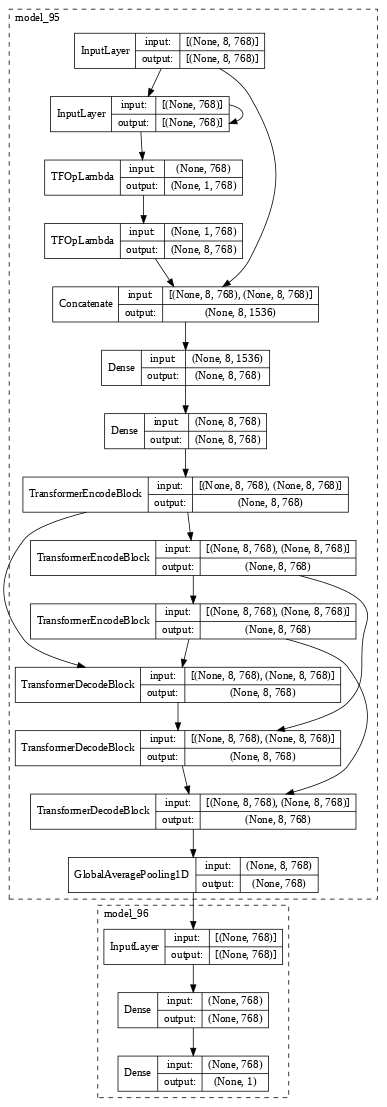

In [ ]:
attention_edge_model_ex, _, _ = attention_edge_predict_model(in_dim=768, embed_dim=768, seq_size=8)
tf.keras.utils.plot_model(
    attention_edge_model_ex, show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=True, dpi=55
    )

In [ ]:
gc.collect()
tf.random.set_seed(0)
attention_edge_model_txt, _, _ = attention_edge_predict_model(in_dim=768, embed_dim=1024, seq_size=set_len, reg1=1e-4, n_heads=8, lr=5e-6, rate=0.5)
attention_edge_model_txt.fit(X_edges_train_txt, y_edges_train_txt, epochs=1, batch_size=128,shuffle=True)

1819/1819 [==============================] - 734s 399ms/step - loss: 0.0698 - accuracy: 0.9800


In [ ]:
import sklearn
 
gc.collect()
threshold_acc = 0.9
preds = attention_edge_model_txt.predict(X_edges_test_txt)

y_preds = (preds >= threshold_acc)
matrix = sklearn.metrics.confusion_matrix(y_edges_test_txt, y_preds)
print('Text Edges\nf1, accuracy, recall, precision')
print(sklearn.metrics.f1_score(y_edges_test_txt, y_preds))
print(sklearn.metrics.accuracy_score(y_edges_test_txt, y_preds))
print(sklearn.metrics.recall_score(y_edges_test_txt, y_preds))
print(sklearn.metrics.precision_score(y_edges_test_txt, y_preds))
print()
print(matrix)
print()
print(f'total preds: {len(np.where(y_preds > threshold_acc)[0])}')
print(f'positive samples: {len(np.where(y_edges_test_txt > threshold_acc)[0])}')

Text Edges
f1, accuracy, recall, precision
0.5754085186177338
0.8911401098901099
0.5163461538461539
0.6497277676950998

[[47604  2316]
 [ 4024  4296]]

total preds: 6612
positive samples: 8320


# Construct graph based on Self-Attention model

In [ ]:
import networkx as nx
 
def gauss_sim(dist,sigma):
    return np.exp(-dist**2/(2.*(sigma**2.)))
 
def construct_graph(X_train, y_train, X_test, y_test, amodel, labels, x_nodes_by_class,y_nodes_by_class):
    G = nx.Graph()
    for i in range(X_train.shape[0]):
        G.add_node(i)
        G.nodes[i]['color'] = labels[int(np.where(y_train[i] == 1)[0])]
    for i in range(X_train.shape[0]):
        for j in range(i, X_train.shape[0]):
            if np.where(y_train[i] == 1)[0] == np.where(y_train[j] == 1)[0]:
                G.add_edge(i, j, weight=1.0)

    oks = [0]*7
    y_preds_att = []
    for k, row in tqdm(zip(range(len(X_test)), X_test), total=len(X_test)):
        
        index = k+len(X_train)
        G.add_node(index)
        G.nodes[index]['color'] = labels[int(np.where(y_test[k] == 1)[0])]
        scores = np.array([0.]*7) # try scoring with Bayesian conditional probability-based method

        n_rows = np.array([row]*len(x_nodes_by_class))

        probs = amodel.predict([n_rows, np.array(x_nodes_by_class)])
        for i in range(len(probs)):
            scores[ y_nodes_by_class[i] ] += probs[i][0]
        label = np.argmax(scores)
        res = [0, 0, 0, 0, 0, 0, 0]
        res[label] += 1
        y_preds_att.append(res)
        indexes = []
        dists = []
        for i in range(len(X_train)):
            if np.where(y_train[i])[0] == label:
                indexes.append(i)
                dists.append(np.linalg.norm(row-X_train[i]))

        neighbors = [(indexes[i], dists[i]) for i in range(len(indexes))]
 
        sigma = sorted([d[1] for d in neighbors])[0]
        n_sim = [(index, n[0], gauss_sim(n[1], sigma)) for n in neighbors]
        G.add_weighted_edges_from(n_sim)

    return G, y_preds_att

In [ ]:
colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
G, y_preds_att = construct_graph(X_txt, y_train, X_txt_test, y_test, attention_edge_model_txt, colores, x_nodes_by_class,y_nodes_by_class)

##t-sne+knn

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, init='pca').fit_transform(np.concatenate((X_txt,X_txt_test), axis=0))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neighs_tsne = KNeighborsClassifier(n_neighbors=10)
neighs_tsne.fit(X_txt[:len(y_train)], y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_preds_edges_tsne = neighs_tsne.predict(X_txt_test)
print('Text Edges\nf1, accuracy, recall, precision')
print(sklearn.metrics.f1_score(y_test, y_preds_edges_tsne, average='macro'))
print(sklearn.metrics.accuracy_score(y_test, y_preds_edges_tsne))
print(sklearn.metrics.recall_score(y_test, y_preds_edges_tsne, average='macro'))
print(sklearn.metrics.precision_score(y_test, y_preds_edges_tsne, average='macro'))
print()
print(f'total preds: {len(np.where(y_preds_edges_tsne > threshold_acc)[0])}')
print(f'positive samples: {len(np.where(y_test > threshold_acc)[0])}')

Text Edges
f1, accuracy, recall, precision
0.5573318266259443
0.5615384615384615
0.5470890947636617
0.5765123863310507

total preds: 244
positive samples: 260


In [ ]:
#matrix = sklearn.metrics.confusion_matrix(y_test, y_preds_edges_tsne)
print('Text Edges\nf1, accuracy, recall, precision')
print(sklearn.metrics.f1_score(y_test, y_preds_att, average='macro'))
print(sklearn.metrics.accuracy_score(y_test, y_preds_att))
#print(sklearn.metrics.balanced_accuracy_score(y_edges_test_txt, y_preds))
print(sklearn.metrics.recall_score(y_test, y_preds_att, average='macro'))
print(sklearn.metrics.precision_score(y_test, y_preds_att, average='macro'))
print()
#,print(matrix)
print()
print(f'total preds: {len(np.where(np.array(y_preds_att) > threshold_acc)[0])}')
print(f'positive samples: {len(np.where(y_test > threshold_acc)[0])}')

Text Edges
f1, accuracy, recall, precision
0.5862252484142215
0.6038461538461538
0.5904413041706097
0.5888712674753596


total preds: 260
positive samples: 260


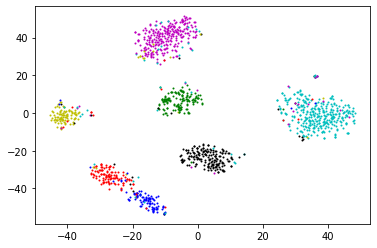

In [ ]:
import matplotlib.pyplot as plt
colors = []
for node in G.nodes():
    colors.append(G.nodes[node]['color'])
    plt.plot(X_embedded[node,0], X_embedded[node,1], f"{G.nodes[node]['color']}o", markersize=1)
plt.show()

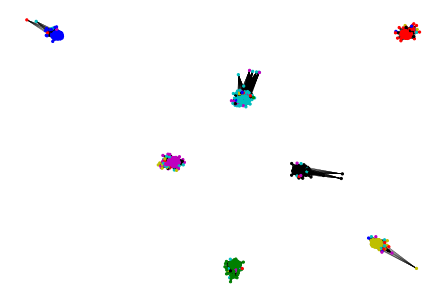

1299


In [ ]:
nx.draw(G, node_size=5, node_color=colors, style='dashed', width=0.05, edge_color='black')
plt.show()
print(len(G.nodes))

In [ ]:
for i,row in zip(range(len(X_im)), X_im):
  G.nodes[i]['y_img'] = 1.0*row
for i,row in zip(range(len(X_im_test)), X_im_test):
  index = i + len(X_im)
  G.nodes[index]['y_img'] = 1.0*row

for i,row in zip(range(len(X_txt)), X_txt):
  G.nodes[i]['y_txt'] = 1.0*row
for i,row in zip(range(len(X_txt_test)), X_txt_test):
  index = i + len(X_im)
  G.nodes[index]['y_txt'] = 1.0*row

In [ ]:
import random
 
def get_prop(G, prop_rate, iter):
  L = np.zeros((len(G.nodes()), len(G.nodes())), dtype=np.float64)
  for node, i in zip(G.nodes(), range(len(G.nodes()))):
    for neighbor, j in zip(G.nodes(), range(len(G.nodes()))):
      if i == j:
        L[i,i] = 1.0
      elif neighbor in G[node]:
        L[i,j] = -G[node][neighbor]['weight']/np.sqrt(G.degree[node]*G.degree[neighbor])
  
  P = np.linalg.matrix_power(prop_rate*L, -iter)
 
  for node, i in zip(G.nodes(), range(len(G.nodes()))):
    for neighbor, j in zip(G.nodes(), range(len(G.nodes()))):
      if neighbor in G[node]:
        G[node][neighbor]['p'] = P[i,j]
 
def regularization(G, prop_rate=1., mi=0.1, iter=1):
    get_prop(G, prop_rate, iter)
    nodes = [i for i in G.nodes()]
    nodes = sorted(nodes)
    for node in nodes:
        G.nodes[node]['f_txt'] = 1.0*G.nodes[node]['y_txt']
        G.nodes[node]['f_img'] = 1.0*G.nodes[node]['y_img']
    #for node in nodes[len(X_txt):]:
    for node in nodes:
        f_new = np.zeros_like(G.nodes[node]['y_txt'])
        f_new_im = np.zeros_like(G.nodes[node]['y_img'])
 
        for neighbor in G[node].keys():
            w = G[node][neighbor]['p']
            f_new += w*G.nodes[neighbor]['y_txt']
            f_new_im += w*G.nodes[neighbor]['y_img']

        G.nodes[node]['f_txt'] = ((1.0-mi)*G.nodes[node]['y_txt'])+(mi*f_new)
        G.nodes[node]['f_img'] = ((1.0-mi)*G.nodes[node]['y_img'])+(mi*f_new_im)
        #G.nodes[node]['f_txt'] = np.concatenate((G.nodes[node]['y_txt'], f_new), axis=0)
        #G.nodes[node]['f_img'] = np.concatenate((G.nodes[node]['y_img'], f_new_im), axis=0)

In [ ]:
mi = 0.1
regularization(G, mi=mi)
gc.collect()

66553

In [ ]:
def get_dataset(G, index, l, labels):
    X_txt = []
    X_im = []
    X_bs_txt = []
    X_bs_im = []
    for i in range(l):
        k = i+index
        X_txt.append(G.nodes[k]['f_txt'])
        X_bs_txt.append(G.nodes[k]['y_txt'])
        X_im.append(G.nodes[k]['f_img'])
        X_bs_im.append(G.nodes[k]['y_img'])

    X_txt = np.array(X_txt)
    X_im = np.array(X_im)
    X_bs_txt = np.array(X_bs_txt)
    X_bs_im = np.array(X_bs_im)

    mean_txt = np.mean(X_txt, axis=0)
    mean_im = np.mean(X_im, axis=0)
    std_txt = np.std(X_txt, axis=0)
    std_im = np.std(X_im, axis=0)
    X_txt = (X_txt-mean_txt)/(std_txt+1e-5)
    X_im = (X_im-mean_im)/(std_im+1e-5)

    mean_txt = np.mean(X_bs_txt, axis=0)
    mean_im = np.mean(X_bs_im, axis=0)
    std_txt = np.std(X_bs_txt, axis=0)
    std_im = np.std(X_bs_im, axis=0)
    X_bs_txt = (X_bs_txt-mean_txt)/(std_txt+1e-5)
    X_bs_im = (X_bs_im-mean_im)/(std_im+1e-5)

    return [X_txt, X_im], [X_bs_txt, X_bs_im]

In [ ]:
def clf_intent(size_im=512, size_txt=768):
    inp_txt = Input(shape=(size_txt,))
    inp_img = Input(shape=(size_im,))
    size = size_txt+size_im
    x = layers.concatenate([inp_txt, inp_img])
    x = Dense(size//2, activation='relu', kernel_constraint=constraints.MaxNorm(3))(x)
    x = Dropout(0.1)(x)
    x = Dense(size//4, activation='relu', kernel_constraint=constraints.MaxNorm(3))(x)
    x = Dropout(0.1)(x)
    x = Dense(size//8, activation='relu', kernel_constraint=constraints.MaxNorm(3))(x)
    x = Dropout(0.1)(x)

    x = Dense(7, activation='softmax')(x)

    clf_model = Model(inputs=[inp_txt, inp_img], outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss=tf.keras.losses.CategoricalCrossentropy()
    clf_model.compile(optimizer=opt,
                    loss=loss,
                    metrics=['accuracy'])
    return clf_model

In [ ]:
def clf_intent(size_im=512, size_txt=768):
    inp_txt = Input(shape=(size_txt,))
    inp_img = Input(shape=(size_im,))
    size = size_txt+size_im

    x = Dense(1024, activation='relu', kernel_constraint=constraints.MaxNorm(3))(inp_txt)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)

    y = Dense(1024, activation='relu', kernel_constraint=constraints.MaxNorm(3))(inp_img)
    y = Dropout(0.5)(y)
    y = Dense(512)(y)

    att_score = layers.Dot([-1, 1])([x, y])
    att = att_score * (x+y)
    fusion = layers.LayerNormalization(epsilon=1e-6)(att)
    fusion = layers.Dense(64)(fusion)
    out = Dense(7, activation='softmax')(fusion)

    clf_model = Model(inputs=[inp_txt, inp_img], outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss=tf.keras.losses.CategoricalCrossentropy()
    clf_model.compile(optimizer=opt,
                    loss=loss,
                    metrics=['accuracy'])
    return clf_model

(768,)
Epoch 1/10
65/65 [==============================] - 1s 4ms/step - loss: 2.9802 - accuracy: 0.2148
Epoch 2/10
65/65 [==============================] - 0s 4ms/step - loss: 1.9424 - accuracy: 0.5330
Epoch 3/10
65/65 [==============================] - 0s 4ms/step - loss: 1.1856 - accuracy: 0.8125
Epoch 4/10
65/65 [==============================] - 0s 4ms/step - loss: 1.0936 - accuracy: 0.7936
Epoch 5/10
65/65 [==============================] - 0s 4ms/step - loss: 0.9041 - accuracy: 0.8021
Epoch 6/10
65/65 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.8878
Epoch 7/10
65/65 [==============================] - 0s 4ms/step - loss: 0.2604 - accuracy: 0.9710
Epoch 8/10
65/65 [==============================] - 0s 4ms/step - loss: 0.2953 - accuracy: 0.9619
Epoch 9/10
65/65 [==============================] - 0s 4ms/step - loss: 0.2523 - accuracy: 0.9688
Epoch 10/10
65/65 [==============================] - 0s 4ms/step - loss: 0.2343 - accuracy: 0.9738
Epoch 1/10
6

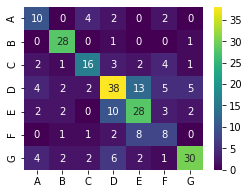

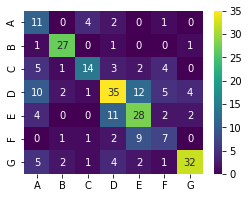

In [ ]:
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
import seaborn as sn

epochs = 10
bs = 16
experiments = []
labels = [[1,0,0,0,0,0,0], [0,1,0,0,0,0,0], [0,0,1,0,0,0,0], 
          [0,0,0,1,0,0,0], [0,0,0,0,1,0,0], [0,0,0,0,0,1,0], [0,0,0,0,0,0,1]]
tf.random.set_seed(None)
X_clf, X_clf_bs = get_dataset(G, 0, len(y_train), labels)
X_clf_test, X_clf_test_bs = get_dataset(G, len(y_train), len(y_test),labels)

print(G.nodes[0]['y_txt'].shape)

clf = clf_intent()
clf.fit(X_clf, y_train, epochs=epochs, batch_size=bs, verbose=1)
auc = roc_auc_score(y_test, clf.predict(X_clf_test), multi_class='ovr')
y_preds = clf.predict(X_clf_test)
cm = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),np.argmax(np.rint(y_preds), axis=1))
f1 = sklearn.metrics.f1_score(np.argmax(y_test, axis=1),np.argmax(np.rint(y_preds), axis=1), average='macro')

clf_bs = clf_intent()
clf_bs.fit(X_clf_bs, y_train, epochs=epochs, batch_size=bs, verbose=1)
auc_bs = roc_auc_score(y_test, clf_bs.predict(X_clf_test_bs), multi_class='ovr')
y_preds_bs = clf_bs.predict(X_clf_test_bs)
cm_bs = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis=1),np.argmax(np.rint(y_preds_bs), axis=1))
f1_bs = sklearn.metrics.f1_score(np.argmax(y_test, axis=1),np.argmax(np.rint(y_preds_bs), axis=1), average='macro')

acc = clf.evaluate(X_clf_test, y_test, verbose=1)
acc_bs = clf_bs.evaluate(X_clf_test_bs, y_test, verbose=1)
print((acc[1], auc, f1), (acc_bs[1], auc_bs, f1_bs))

df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFG"],
                  columns = [i for i in "ABCDEFG"])
plt.figure(figsize=(4,3))
sn.heatmap(df_cm, annot=True, cmap='viridis')

plt.show()

df_cm = pd.DataFrame(cm_bs, index = [i for i in "ABCDEFG"],
                  columns = [i for i in "ABCDEFG"])
plt.figure(figsize=(4,3))
sn.heatmap(df_cm, annot=True, cmap='viridis')

plt.show()

ep_dict = {
          'split':split,
          'bert_ratio':int(100.0),
          'acc':str(acc).replace('.', ',')[:10],
          'auc_roc':str(auc).replace('.', ',')[:10],
          'mi':mi,
          'trans':True
      }
bs_dict = ep_dict.copy()
bs_dict['acc'] = str(acc_bs).replace('.', ',')[:10]
bs_dict['auc_roc'] = str(auc_bs).replace('.', ',')[:10]
bs_dict['mi'] = "None"
bs_dict['trans'] = False

experiments.append(ep_dict)
experiments.append(bs_dict)

In [ ]:
import os
path = f'/content/drive/My Drive/bert_models/{np.random.randint(99999)}_split{split}.csv'
while os.path.isfile(path):
  path = f'/content/drive/My Drive/bert_models/{np.random.randint(99999)}_split{split}.csv'

import csv
fields = experiments[0].keys()
with open(path, 'w') as op:
    writer = csv.DictWriter(op, fieldnames=fields)
    writer.writeheader()
    for d in experiments:
        writer.writerow(d)

# Evaluation
 
Cenário 1) quando todas as instâncias possuem textos/captions associadas.
2) simular cenários:
Cenário 2.1) Todo o treino tem texto associado, mas nenhum no teste tem. Então propagamos embeddings BERT. Esse parece ser um cenário prático, pois em geral o treino tem condições de ser gerado com mais calma.
Cenários 2.2) Todo o treino tem texto associado, mas o teste uma parcela de 10%,20%,..,70% de texto associado. Também parece ser um cenário prático, onde o teste pode ter ou não texto associado.
 
Para comparar com os resultados estado da arte (na qual já temos os resultados no paper publicado), é o cenário (1).
Os cenários em (2) comparamos apenas entre nossa abordagem.
 
** Compare results of transdutive with indutive limiting samples in training set.

# O que investigar nos próximos passos?

* Peso nas arestas com base na confiança de classificação?
* Peso por tipo de relação? Qual é mais importante: Imagem ou Textos?
* Cenários em que o nem todas as imagens possuem captions? (interessante para o SNAP)
* Melhorar o regularizador (usar GNetMine)?